In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.seasonal import _extrapolate_trend

In [50]:
import statsmodels.api as sm

# Load the sunspots dataset
sunspots_data = sm.datasets.sunspots.load_pandas().data

In [51]:
# View the first few rows
sunspots_data.head()

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


In [52]:
# Preprocess the data

# Convert the 'YEAR' column to datetime and set as index
sunspots_data['Date'] = pd.to_datetime(sunspots_data['YEAR'], format='%Y')
sunspots_data.set_index('Date', inplace=True)

# Drop the 'YEAR' column as it's now redundant
sunspots_data.drop(columns=['YEAR'], inplace=True)

# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)
# df.drop(columns=['Unnamed: 0', 'Other_irrelevant_column'], inplace=True, errors='ignore')  # drop unwanted columns if necessary
# df.rename(columns={df.columns[0]: 'values'}, inplace=True)  # Rename the main data column to 'values'

sunspots_data.head()


,SUNACTIVITY
Date,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0


In [53]:
y_hist = sunspots_data.loc['1900':'1984','SUNACTIVITY']
y_future = sunspots_data.loc['1985':'2000','SUNACTIVITY']

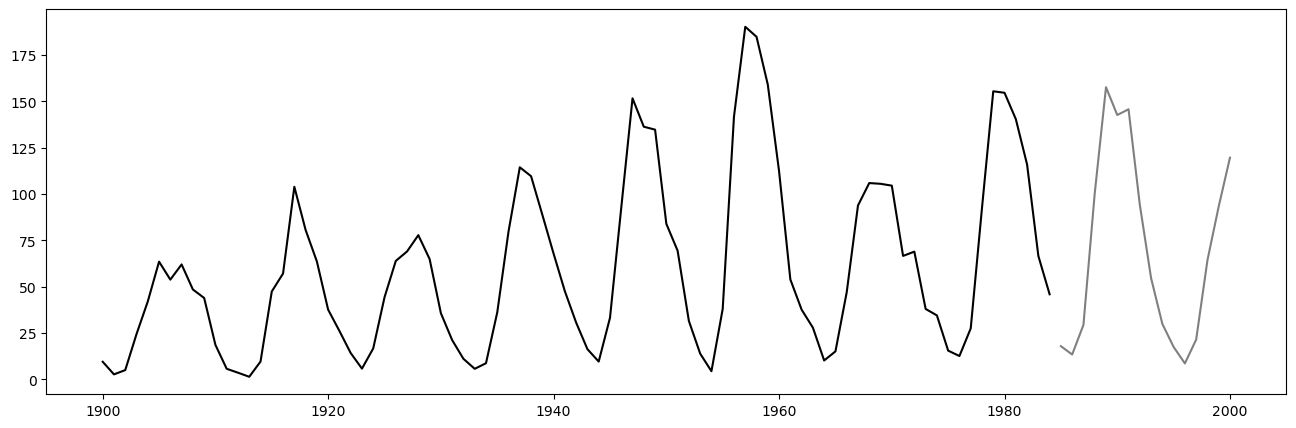

In [54]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k')
plt.plot(y_future,'k',alpha=0.5)

In [55]:
# Use only 1900 to 1984 for modeling
y_hist = sunspots_data.loc['1900-01-01':'1984-12-31', 'SUNACTIVITY']


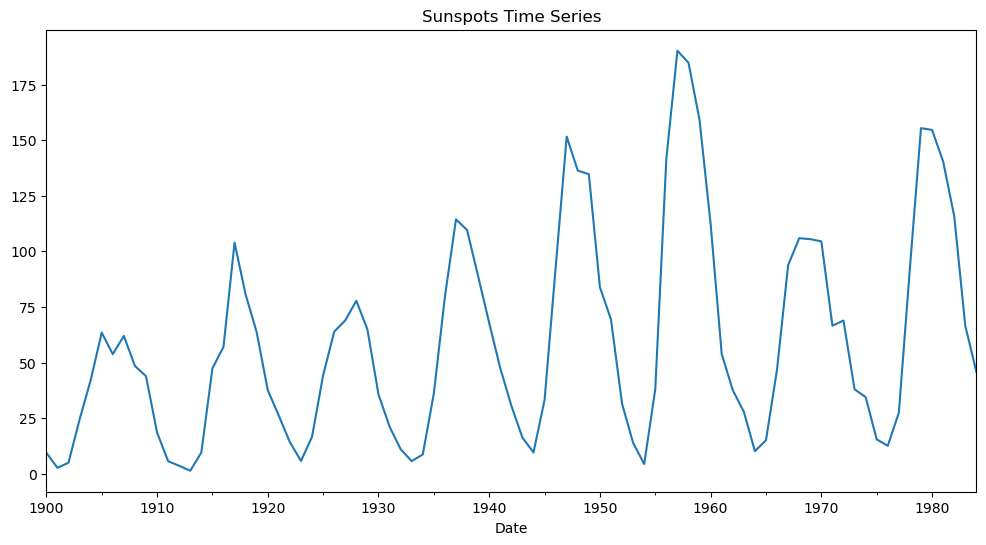

In [56]:
# Plot the data
y_hist.plot(figsize=(12, 6))
plt.title("Sunspots Time Series")
plt.show()

## Extract the trend

In [57]:
# Define the period and filter length
period = 10  # approximate sunspot cycle period in months
filter_len = period + 1  # length of the filter is period + 1 = 129

# Build the smoothing filter as described
# All ones with first and last element half
filter_weights = np.ones(filter_len)
filter_weights[0] = 0.5
filter_weights[-1] = 0.5

# Normalize so that sum of weights = 1 (preserves mean)
filter_weights /= filter_weights.sum()

# Apply smoothing filter using convolution
trend = np.convolve(y_hist, filter_weights, mode='same')

# Create a pandas Series for convenience with aligned index
trend_series = pd.Series(trend, index=y_hist.index)

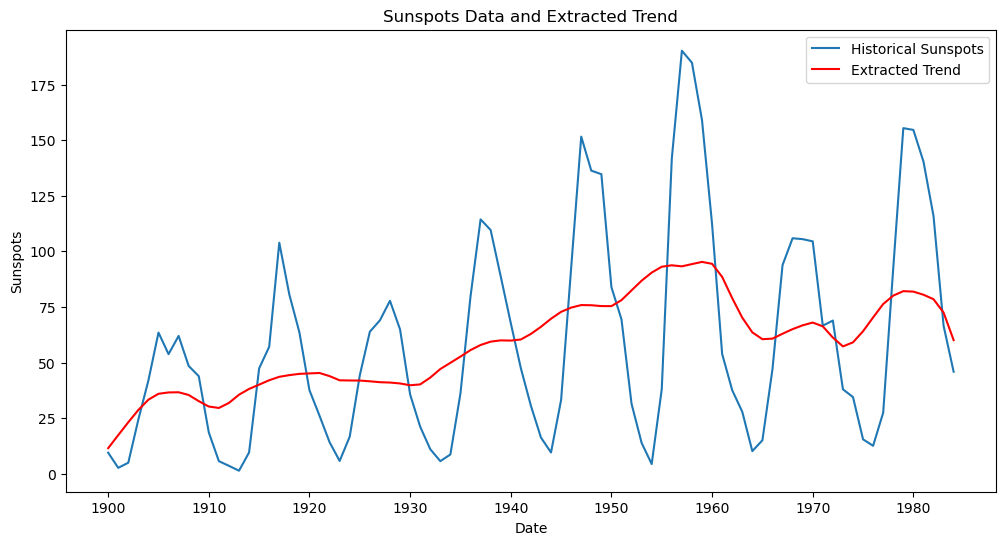

In [58]:
# Plot the original data and extracted trend
plt.figure(figsize=(12, 6))
plt.plot(y_hist, label='Historical Sunspots')
plt.plot(trend_series, label='Extracted Trend', color='red')
plt.title('Sunspots Data and Extracted Trend')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.legend()
plt.show()

In [59]:
trend = convolution_filter(y_hist, filter_weights)
trend = _extrapolate_trend(trend, period + 1)

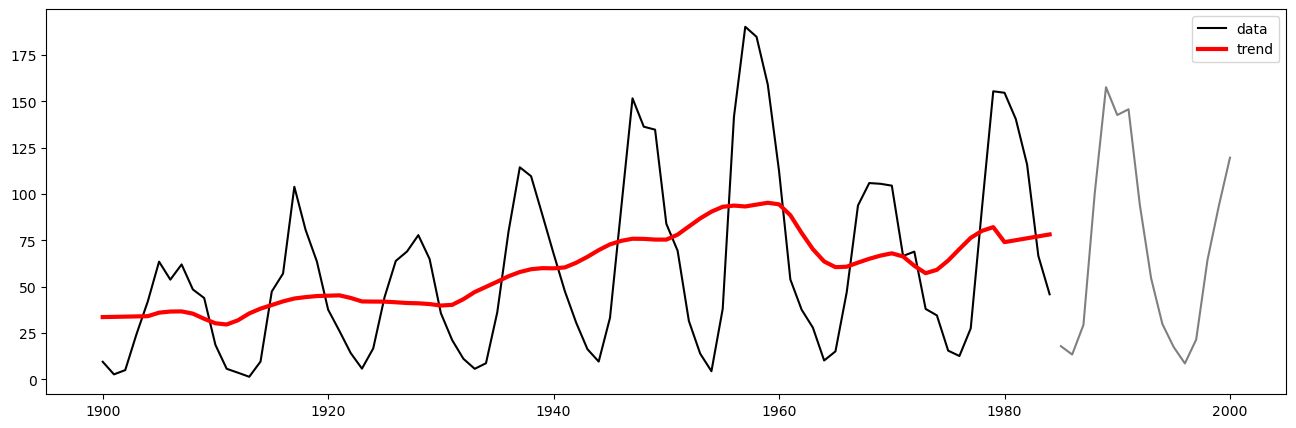

In [60]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data')
plt.plot(trend,'r',linewidth=3,label='trend')
plt.plot(y_future,'k',alpha=0.5)
plt.legend()

## Detrended data

In [61]:
detrended = y_hist - trend
detrended = detrended.to_numpy()

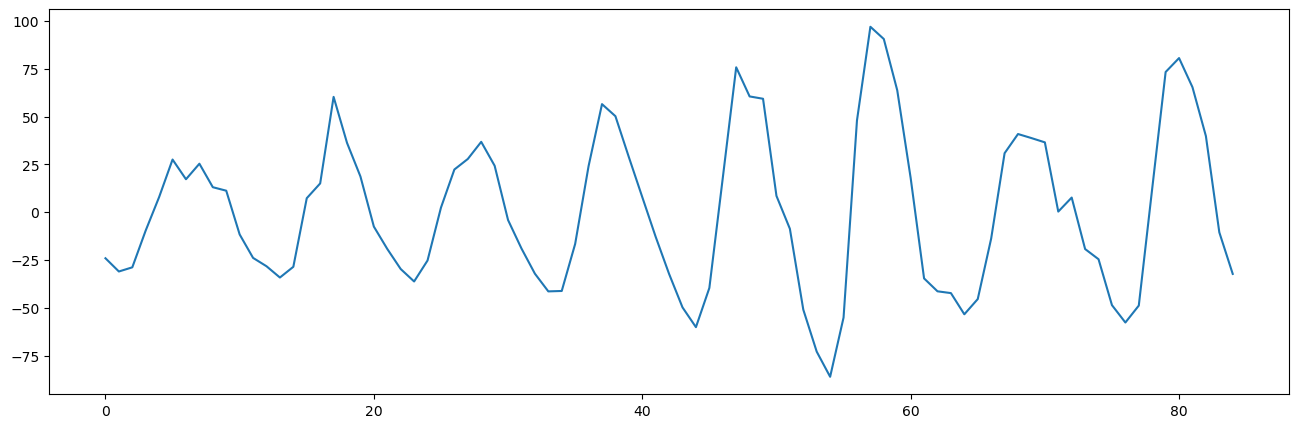

In [62]:
plt.figure(figsize=(16,5))
plt.plot(detrended)

Here is a detailed beginner-friendly explanation covering Video 9 on time series decomposition of sunspots data, including Python implementation details and additional context from relevant sources:

***

## Preparing the Sunspots Data for Decomposition

The first step is loading the solar sunspots data (from a CSV file, e.g., "Sunspots.csv"). Then preprocess it to prepare for analysis:

- Convert the date column into a **datetime index** for the DataFrame. This allows convenient time-based slicing and plotting.
- Drop any irrelevant columns for the analysis.
- Rename the column with sunspot values to a simple name like `values` for clarity.

Only use data from 1900 to 1984 (called `y_hist`) to build the model; data from 1985 onward (`y_future`) will be reserved for forecast validation.

Using a timestamp index enables clean time slicing using notation like `df["1900":"1984"]`—which would not work properly if the index were plain strings.

***

## Extracting the Trend Component

The trend represents the long-term pattern or movement in the data.

- Since solar sunspots have an approximate period (~128 months), build a smoothing **filter** with length 129.
- The filter is a weighted moving average where all weights are 1, but the first and last weights are halved (to smooth edge effects).
- Normalize the filter to ensure the sum of weights equals 1, preserving the signal mean.

Applying this filter (a convolution) to the historical data extracts the trend component.

A practical issue is the trend ends before the start and end of the data, so the trend is **extrapolated** to cover the entire timeline using a custom function (`extrapolate_trend`), which extends the trend flatly at the edges.

***

## Detrending the Data

Subtract the trend from the historical data to obtain **detrended data** with a mean near zero, removing long-term movement and isolating seasonal and cyclic fluctuations.

***

## Identifying and Segmenting Seasons

Unlike fixed-period seasons, sunspot cycles vary slightly in length and amplitude.

- Manually identify approximate cycle boundaries by locating minima points in the detrended data where sunspot numbers approach zero.
- These minima determine start and end dates for cycles (seven cycles found between 1900-1984).
- Plot vertical lines to mark these cycle boundaries.

***

## Averaging and Normalizing Seasonal Cycles

Create a matrix to align cycles for averaging:

- Calculate the average cycle length (~128 months).
- For each identified season, extract the corresponding detrended data segment.
- Normalize the cycle data to oscillate between 0 and 2 (bottoming at zero, peak near twice the trend) to allow a multiplicative decomposition model.

Take the mean across cycles to obtain a **mean seasonal template** representing typical cycle behavior.

***

## Smoothing the Seasonal Template and Removing Outliers

The raw average seasonal template is jagged due to noise and irregularities.

- Smooth the mean seasonal template via convolution with a shorter smoothing filter (~9 months length).
- Inspect cycles manually and discard obvious outliers to improve the seasonal template.
- Recompute the average of cleaned cycles yielding a smoother, more representative seasonal pattern.

***

## Constructing the Full Seasonal Signal

Repeat the smoothed seasonal template across the historical time index, filling in time periods to represent the entire seasonal component.

***

## Final Model Assembly

The complete modeled time series is obtained by multiplying the seasonal component by the trend (scaled by 2).

***

## Residual Calculation and Error Metrics

Compute **residuals** as the difference between the original historical data and the modeled data.

Check residual size via error metrics:

- **Mean Absolute Error (MAE)**: average absolute difference.
- **Root Mean Squared Error (RMSE)**: square root of average squared differences.

These quantify how well the decomposition fits the historical data.

***

## Stationarity Check via Autocorrelation Function (ACF)

Plot the autocorrelation of residuals to assess stationarity:

- Stationary residuals show autocorrelation that decays exponentially or cuts off quickly.
- Observed residual autocorrelations that oscillate up and down without clear exponential decay indicate residual non-stationarity.
- Non-stationary residuals may imply unmodeled trend or seasonal structure still present.

***

## Forecasting Future Sunspots

Project the trend forward flatly by extending the last trend value over future timestamps.

Project seasonal cycles into the future by repeating historical seasonal templates.

Compute the forecast as the product of the projected trend and seasonal components.

***

## Forecast Validation

When future actual data becomes available, calculate the prediction error by subtracting the forecast values from actual sunspots.

Calculate MAE and RMSE for forecast errors and compare them to training residual errors:

- Forecast errors are reasonably larger, as expected, since forecasting is more challenging than fitting historical data.

***

## Python Implementation Insights

- Use **pandas** for date handling, filtering, indexing, and data manipulation.
- Filtering (smoothing) is done by applying a custom weight array via **convolution**.
- Manual identification and removal of outliers involve direct inspection and slicing.
- Multiplicative decomposition models incorporate scaling seasonal components before combining with trends.
- Plotting with **matplotlib** provides visual diagnostics at every step.
- Residual autocorrelation analysis leverages the ACF function from **statsmodels** or similar libraries.

***

## Additional Context on Decomposition in Python

- **statsmodels** offers `seasonal_decompose()` for classical decomposition (additive or multiplicative), automatically estimating trend, seasonality, and residuals.
- STL (Seasonal-Trend decomposition using Loess) provides a more flexible, robust alternative to classical decomposition.
- Real-world series often require manual tuning in cycle identification and smoothing parameters.
  
This hands-on approach is foundational for deeper time series modeling and forecasting, where residual analysis guides model refinement and the interplay between components clarifies data complexity.

***

This comprehensive explanation provides both conceptual understanding and Python-oriented practical guidance to execute and interpret detailed time series decomposition like that applied to solar sunspots data in the video.[1][3][4][6][7]

[1](https://www.machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)
[2](https://www.blog.trainindata.com/multi-seasonal-time-series-decomposition-using-mstl-in-python/)
[3](https://www.geeksforgeeks.org/python/time-series-decomposition-techniques/)
[4](https://www.statology.org/how-to-perform-seasonal-decomposition-of-time-series-in-python/)
[5](https://www.youtube.com/watch?v=DAliigYvEY8)
[6](https://www.datascienceconcepts.com/tutorials/python-programming-language/time-series-decomposition-classical-method-in-python/)
[7](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html)
[8](https://stackoverflow.com/questions/67835998/decompose-annual-time-series-with-statsmodels)
[9](https://www.kaggle.com/code/bextuychiev/advanced-time-series-analysis-decomposition)